# Reproducing the test for the SINDy autoencoder in the case of the lorenz system. this is our best model so far

In [ ]:
!pip install tensorflow==1.15 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 21 kB/s 
     |████████████████████████████████| 3.8 MB 36.0 MB/s 
     |████████████████████████████████| 503 kB 50.2 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e307c3ce5add3e3c1b616722ab29374cf6f7101fddbdbe293df80e70ae42d36b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/

/gdrive/MyDrive


In [ ]:
import sys
#sys.path.append("../../src")
import os
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
from myautoencoder import full_network
from mytraining import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

loading the model

In [ ]:
data_path = os.getcwd() + '/'
save_name = 'lorenz_2022_11_30_16_04_13_918174'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Single trajectory plots

the first method to asses what the model learned is to generate some test data and compare the learned dynamis of the mode (in the coordinates extracted by the autoencoder and with the parameters learned in the sundy part) with the parameters of the lorenz model used to simulate the data

generating test data

In [ ]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

restoring the comptational graph and running the model on the test data

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

let us look at the learned coefficients of the sindy model on the latent space

In [ ]:
params['coefficient_mask']*test_set_results['sindy_coefficients']

array([[ 0.        , -0.        ,  6.9266534 ],
       [-0.        , -7.516779  ,  7.1002016 ],
       [ 0.        , -5.415417  ,  4.8453083 ],
       [-0.        ,  2.7231636 , -7.6884866 ],
       [ 0.        , -0.        , -0.06566215],
       [ 0.13754363,  2.5215757 ,  2.3446722 ],
       [-0.        , -2.6745706 , -2.3295438 ],
       [-6.391898  ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 7.062371  , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        ],
       [-0.        , -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ],
       [-0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [-0.        , -0.        ,  0.        ],
       [-0.11443269, -0.        , -0.09924021]], dtype=float32)

In [ ]:
Xi_plot = (params['coefficient_mask']*test_set_results['sindy_coefficients'])
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

the final model has 17 active coefficients, 10 more than the 7 in the original model

the model is sparse if we cosider that we started from 81 possi ble tterms,but we have some higher order terms that were not thresholded, running a longer training time, with a larger number of thresholing steps would help

to beter see the behaviour of the learnd model we plot the trajectory of the original, learned and transforme model in one of the test data

In [ ]:
lorenz_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
z_sim = sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])

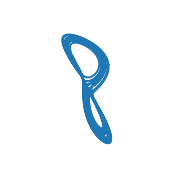

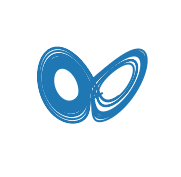

In [ ]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax2.view_init(azim=120)

the model was able to learn the correct attractor behaviour

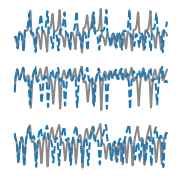

In [ ]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, test_set_results['z'][:,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

the single trajectories are still chaootic

## Test set analysis - in distribution

to evaluate the performance we look at some test data created from initial conditions from the same distribution of the train data (uniformly sampled from a box arround the attractor)

In [ ]:
test_data = get_lorenz_data(100, noise_strength=1e-6)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

let us analyze the different errors commited it the training procedure:
- the reconstruction error of the state itself (reconsttruction loss of the state x)
- the reconstruction error of the derivative of the state
- the reeconstruction error of the derivative of the hidden rappresentation

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000034
Decoder relative SINDy error: 0.000670
SINDy reltive error, z: 0.002330


some plots of the predited trajectories against the ground truth

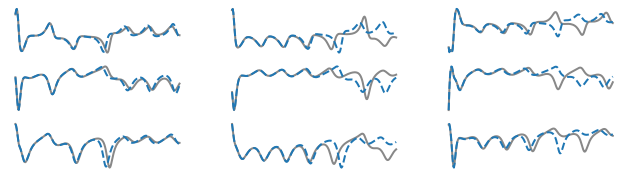

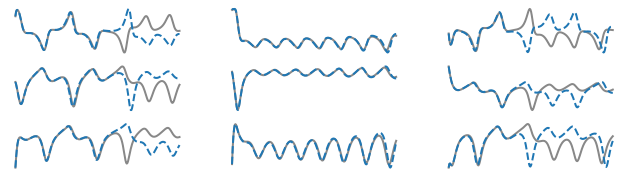

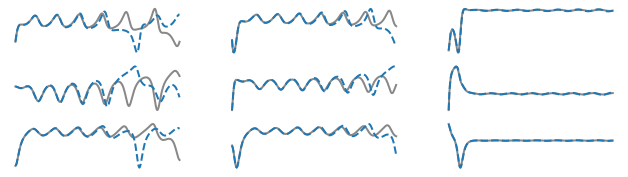

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

we can see that we are able to correctly idenify the behaviour of the system, as time goes on we lose preision faster than the reference model

## Test set analysis - out of distribution

we now sampe data from outside the training distribution, i.e. outside the box surrounding the attractor to asses wheter the model is able to generalize. (in practice we sample from a bigger box to reuse code) and perform the same tests as above

In [ ]:
inDist_ic_widths = np.array([36,48,41]) ## this are the coordinates of the box of the reainind distr
outDist_extra_width = np.array([18,24,20]) ## this gives the enlargement of the box
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-6

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.011082
Decoder relative SINDy error: 0.106514
SINDy reltive error, z: 0.113222


the relative error increases as expected

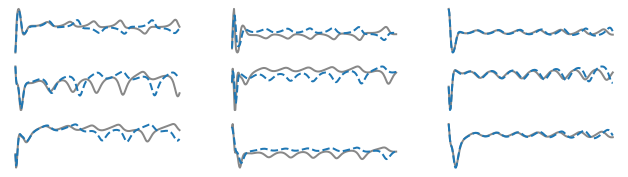

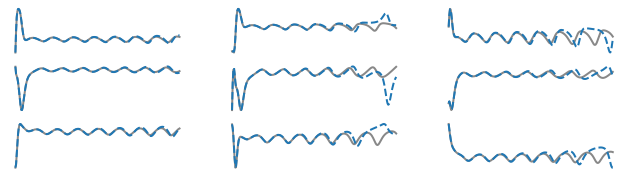

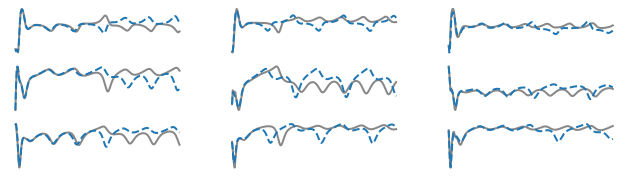

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

the model is able to generalize and predic sensible trajectories also for the initial conditions outise the box

## Test set analysis - in distribution with increasingly higher noise levels


let us increase the ammount of noise in the data and evaluate the performace in that case

noise strength = 1e-4

In [ ]:
test_data = get_lorenz_data(100, noise_strength=1e-4)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000031
Decoder relative SINDy error: 0.000508
SINDy reltive error, z: 0.001703


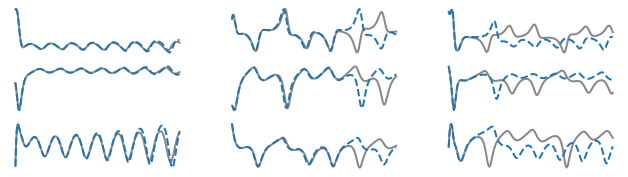

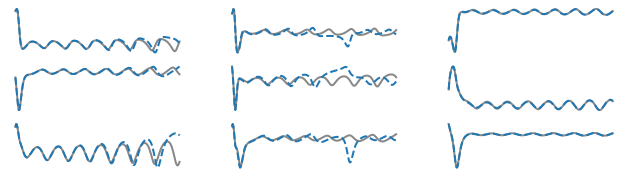

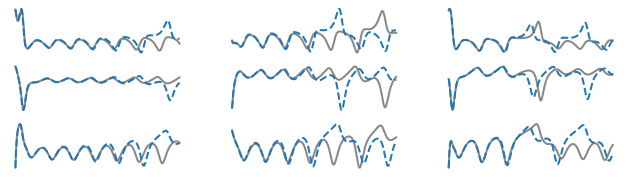

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

noise strength = 1e-2

In [ ]:
test_data = get_lorenz_data(100, noise_strength=1e-2)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000572
Decoder relative SINDy error: 0.000593
SINDy reltive error, z: 0.001833


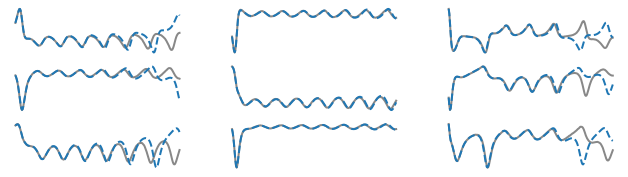

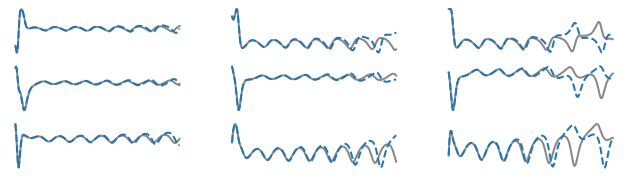

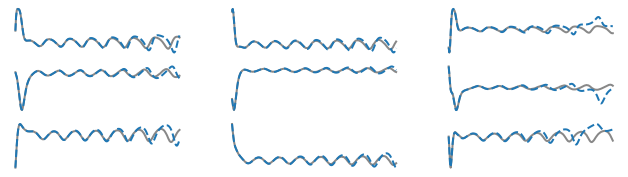

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

noise strength = 1e-1

In [ ]:
test_data = get_lorenz_data(100, noise_strength=1e-1)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.050779
Decoder relative SINDy error: 0.011975
SINDy reltive error, z: 0.014427


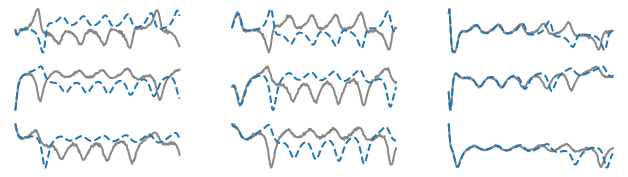

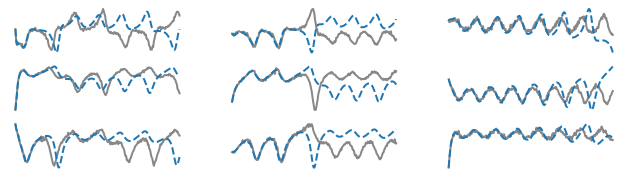

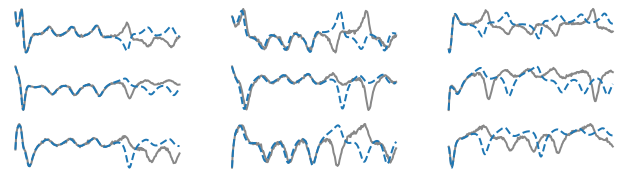

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

the results seem robust even for noisy data
**the model was trained with clean data (error strength = 1e-6) and is able to extrapolate to noisier input data** even with noise that is 5 orders of magnitude stronger

## Test set analysis - out of distribution with increasingly higher noise levels

noise strength = 1e-4

In [ ]:
inDist_ic_widths = np.array([36,48,41]) ## this are the coordinates of the box of the reainind distr
outDist_extra_width = np.array([18,24,20]) ## this gives the enlargement of the box
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-4

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.014323
Decoder relative SINDy error: 0.121454
SINDy reltive error, z: 0.108157


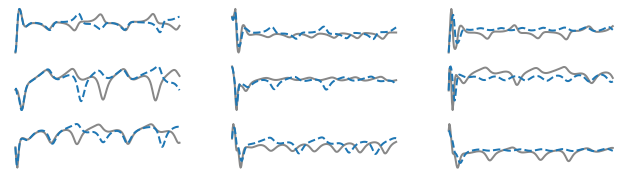

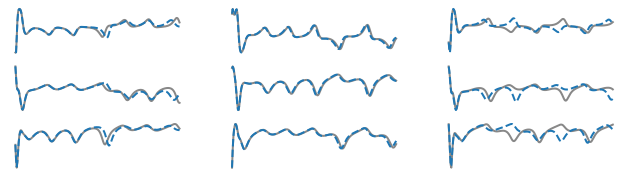

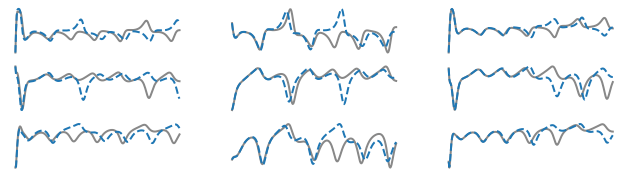

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

noise strength = 1e-2

In [ ]:
inDist_ic_widths = np.array([36,48,41]) ## this are the coordinates of the box of the reainind distr
outDist_extra_width = np.array([18,24,20]) ## this gives the enlargement of the box
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-2

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.015632
Decoder relative SINDy error: 0.131628
SINDy reltive error, z: 0.103691


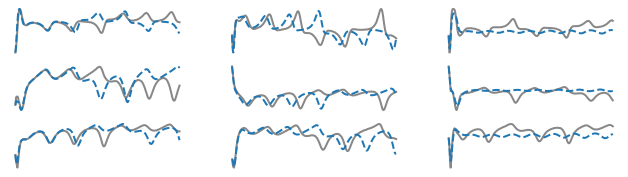

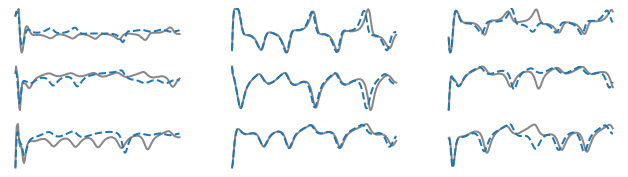

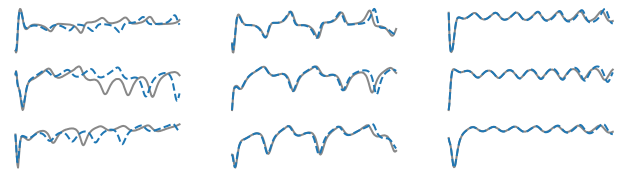

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

noise strength = 1e-1

In [ ]:
inDist_ic_widths = np.array([36,48,41]) ## this are the coordinates of the box of the reainind distr
outDist_extra_width = np.array([18,24,20]) ## this gives the enlargement of the box
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-6

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.010525
Decoder relative SINDy error: 0.089783
SINDy reltive error, z: 0.080827


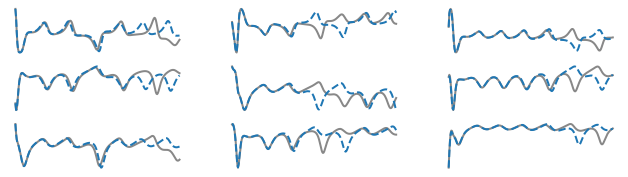

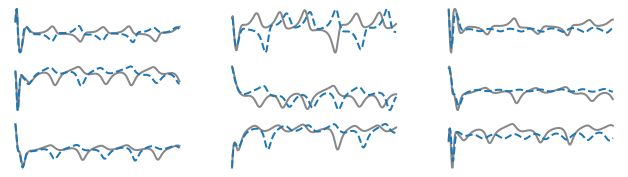

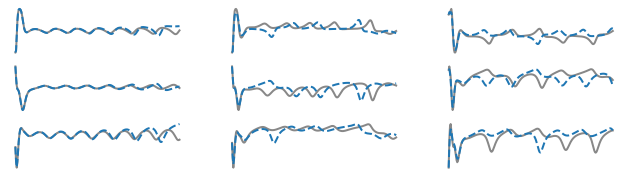

In [ ]:
for ic in range(9,18):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

in the out of distribution case the results are still sensible but with lower performance than the in distribution case